# Visualizing Periodic Lightcurves

## Learning Objectives

In this tutorial, you will learn:

* See a guided tutorial on visualizing the lightcurves for a set of known periodic objects
* How to crossmatch an object list with Rubin data through LSDB Catalogs

## Introduction

This notebook demonstrates how to visualize lightcurves for periodic objects in the Rubin DP1 data.


In [1]:
import astropy.units as u
import lsdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dask.distributed import Client
from io import StringIO
from nested_pandas import NestedDtype
from pathlib import Path

import warnings

# Disable plotting warnings
warnings.filterwarnings("ignore")

## The Rubin HATS catalogs
* HATS (HEALPix Adaptive Tiling Scheme) is a HEALPix-based parquet format that enables fast parallelization of large scale workflows.
* The data was imported and post-processed by the [DASH pipeline](https://github.com/lsst-sitcom/linccf/tree/main/dash).
* It includes added-value columns for scientific use - e.g. PSF and science magnitudes, and timestamps for every source / forced source.

In [2]:
hats_path = UPath("/rubin/lsdb_data")
diaobject_path = hats_path / "dia_object_collection"
object_path = hats_path / "object_collection"

## Load the Rubin DP1 Catalog

The relevant catalogs are diaObject and object. Each row corresponds to a single object with all its sources and nested sources embedded in separate columns.

In [3]:
# Load DiaObject Collection
dia_catalog = lsdb.open_catalog(diaobject_path)
dia_catalog

,dec,diaObjectId,nDiaSources,ra,radecMjdTai,tract,diaObjectForcedSource,diaSource
npartitions=208,,,,,,,,
"Order: 6, Pixel: 130",double[pyarrow],int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],"nested<band: [string], coord_dec: [double], co...","nested<band: [string], centroid_flag: [bool], ..."
"Order: 6, Pixel: 136",...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
"Order: 11, Pixel: 36833621",...,...,...,...,...,...,...,...
"Order: 7, Pixel: 143884",...,...,...,...,...,...,...,...


In [4]:
# Load Object Collection
obj_catalog = lsdb.open_catalog(object_path)
obj_catalog

,coord_dec,coord_decErr,coord_ra,coord_raErr,g_psfFlux,g_psfFluxErr,g_psfMag,g_psfMagErr,i_psfFlux,i_psfFluxErr,i_psfMag,i_psfMagErr,objectId,patch,r_psfFlux,r_psfFluxErr,r_psfMag,r_psfMagErr,refBand,refFwhm,shape_flag,shape_xx,shape_xy,shape_yy,tract,u_psfFlux,u_psfFluxErr,u_psfMag,u_psfMagErr,x,xErr,y,y_psfFlux,y_psfFluxErr,y_psfMag,y_psfMagErr,yErr,z_psfFlux,z_psfFluxErr,z_psfMag,z_psfMagErr,objectForcedSource
npartitions=389,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 6, Pixel: 130",double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],float[pyarrow],bool[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],"nested<band: [string], coord_dec: [double], co..."
"Order: 8, Pixel: 2176",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 9, Pixel: 2302101",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 143884",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Choose the variable objects
We have a selection of 10 variable objects, which were found from previous analysis of forced photometry on science images:

In [5]:
variables_csv = """ra,dec,period
94.95546,-24.73952,0.12095
95.30235,-25.27431,0.12248
94.91626,-24.69648,0.12038
95.12418,-25.04329,0.23554
58.83506,-48.79122,0.56335
94.92264,-25.23185,0.07672
94.72086,-25.05767,0.17559
94.97073,-25.13643,0.12048
59.12997,-48.78522,0.11628
94.72086,-25.05767,0.17554
"""
# We add the index as a column of the DataFrame so we can later retrieve
# all the Rubin data from difference and science imaging
variables_df = pd.read_csv(StringIO(variables_csv)).reset_index()
# Transform the DataFrame into a LSDB Catalog
variables_catalog = lsdb.from_dataframe(variables_df)
variables_catalog

,index,ra,dec,period
npartitions=2,,,,
"Order: 2, Pixel: 80",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow]
"Order: 5, Pixel: 8582",...,...,...,...


## Crossmatch the data
Let's crossmatch the Rubin data with our desired variable objects:

In [6]:
XMATCH_RADIUS_ARCSEC = 0.2
variable_object = variables_catalog.crossmatch(
    obj_catalog, radius_arcsec=XMATCH_RADIUS_ARCSEC, suffixes=["_var", ""]
)
variable_dia = variables_catalog.crossmatch(
    dia_catalog, radius_arcsec=XMATCH_RADIUS_ARCSEC, suffixes=["_var", ""]
)
# The result will have all the columns in obj_catalog suffixed with `_obj`,
# all the columns in dia_catalog suffixed with `_dia`, as well as all the
# columns in `variables_df` suffixed with `_var_obj`
result = variable_object.join(
    variable_dia, left_on="index_var", right_on="index_var", suffixes=["_obj", "_dia"]
)
result

,index_var_obj,ra_var_obj,dec_var_obj,period_var_obj,coord_dec_obj,coord_decErr_obj,coord_ra_obj,coord_raErr_obj,g_psfFlux_obj,g_psfFluxErr_obj,g_psfMag_obj,g_psfMagErr_obj,i_psfFlux_obj,i_psfFluxErr_obj,i_psfMag_obj,i_psfMagErr_obj,objectId_obj,patch_obj,r_psfFlux_obj,r_psfFluxErr_obj,r_psfMag_obj,r_psfMagErr_obj,refBand_obj,refFwhm_obj,shape_flag_obj,shape_xx_obj,shape_xy_obj,shape_yy_obj,tract_obj,u_psfFlux_obj,u_psfFluxErr_obj,u_psfMag_obj,u_psfMagErr_obj,x_obj,xErr_obj,y_obj,y_psfFlux_obj,y_psfFluxErr_obj,y_psfMag_obj,y_psfMagErr_obj,yErr_obj,z_psfFlux_obj,z_psfFluxErr_obj,z_psfMag_obj,z_psfMagErr_obj,objectForcedSource_obj,_dist_arcsec_obj,index_var_dia,ra_var_dia,dec_var_dia,period_var_dia,dec_dia,diaObjectId_dia,nDiaSources_dia,ra_dia,radecMjdTai_dia,tract_dia,diaObjectForcedSource_dia,diaSource_dia,_dist_arcsec_dia
npartitions=8,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 8, Pixel: 329721",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],float[pyarrow],bool[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],"nested<band: [string], coord_dec: [double], co...",double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],"nested<band: [string], coord_dec: [double], co...","nested<band: [string], centroid_flag: [bool], ...",double[pyarrow]
"Order: 9, Pixel: 1324352",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 9, Pixel: 2197038",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 9, Pixel: 2197120",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


And apply filtering according to the quality flags:

In [7]:
for column in ["objectForcedSource_obj", "diaSource_dia", "diaObjectForcedSource_dia"]:
    result = result.query(
        f"~{column}.psfFlux_flag"
        f" and ~{column}.pixelFlags_saturated"
        f" and ~{column}.pixelFlags_cr"
        f" and ~{column}.pixelFlags_bad"
    )
result

,index_var_obj,ra_var_obj,dec_var_obj,period_var_obj,coord_dec_obj,coord_decErr_obj,coord_ra_obj,coord_raErr_obj,g_psfFlux_obj,g_psfFluxErr_obj,g_psfMag_obj,g_psfMagErr_obj,i_psfFlux_obj,i_psfFluxErr_obj,i_psfMag_obj,i_psfMagErr_obj,objectId_obj,patch_obj,r_psfFlux_obj,r_psfFluxErr_obj,r_psfMag_obj,r_psfMagErr_obj,refBand_obj,refFwhm_obj,shape_flag_obj,shape_xx_obj,shape_xy_obj,shape_yy_obj,tract_obj,u_psfFlux_obj,u_psfFluxErr_obj,u_psfMag_obj,u_psfMagErr_obj,x_obj,xErr_obj,y_obj,y_psfFlux_obj,y_psfFluxErr_obj,y_psfMag_obj,y_psfMagErr_obj,yErr_obj,z_psfFlux_obj,z_psfFluxErr_obj,z_psfMag_obj,z_psfMagErr_obj,objectForcedSource_obj,_dist_arcsec_obj,index_var_dia,ra_var_dia,dec_var_dia,period_var_dia,dec_dia,diaObjectId_dia,nDiaSources_dia,ra_dia,radecMjdTai_dia,tract_dia,diaObjectForcedSource_dia,diaSource_dia,_dist_arcsec_dia
npartitions=8,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 8, Pixel: 329721",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],float[pyarrow],bool[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],"nested<band: [string], coord_dec: [double], co...",double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],"nested<band: [string], coord_dec: [double], co...","nested<band: [string], centroid_flag: [bool], ...",double[pyarrow]
"Order: 9, Pixel: 1324352",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 9, Pixel: 2197038",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 9, Pixel: 2197120",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Notice that we instantiate a Dask Client to efficiently parallelize our computations:

In [8]:
with Client(n_workers=20, threads_per_worker=1) as client:
    # Sort light curves by variable object index for plotting purposes
    result_df = result.compute().sort_values("index_var_obj")
result_df

index_var_obj  ra_var_obj  dec_var_obj  period_var_obj  \
_healpix_29                                                                   
1456157018405184225              0    94.95546    -24.73952         0.12095   
1450131236226156835              1    95.30235    -25.27431         0.12248   
1456157750233453047              2    94.91626    -24.69648         0.12038   
1456145241786549427              3    95.12418    -25.04329         0.23554   
2415759959093266587              4    58.83506    -48.79122         0.56335   
1456140633585049253              5    94.92264    -25.23185         0.07672   
1456149791804243835              6    94.72086    -25.05767         0.17559   
2415669000192289034              8    59.12997    -48.78522         0.11628   
1456149791804243835              9    94.72086    -25.05767         0.17554   

                     coord_dec_obj  coord_decErr_obj  coord_ra_obj  \
_healpix_29                                                          
1456157018405184225     -24.739524               0.0     94.955465   
1450131236226156835     -25.274306               0.0     95.302354   
1456157750233453047     -24.696482               0.0      94.91626   
1456145241786549427     -25.043288               0.0     95.124185   
2415759959093266587     -48.791216               0.0     58.835057   
1456140633585049253     -25.231852               0.0     94.922636   
1456149791804243835     -25.057669               0.0     94.720857   
2415669000192289034     -48.785224               0.0     59.129967   
1456149791804243835     -25.057669               0.0     94.720857   

                     coord_raErr_obj  g_psfFlux_obj  g_psfFluxErr_obj  ...  \
_healpix_29                                                            ...   
1456157018405184225              0.0   96215.617188         40.481762  ...   
1450131236226156835              0.0   38424.933594         34.274925  ...   
1456157750233453047              0.0   333769.84375         75.333427  ...   
1456145241786549427              0.0     1447216.25        131.617188  ...   
2415759959093266587              0.0  227908.046875         62.881378  ...   
1456140633585049253              0.0  114717.398438         40.412148  ...   
1456149791804243835              0.0    234904.0625         57.171268  ...   
2415669000192289034              0.0   15816.786133         24.092821  ...   
1456149791804243835              0.0    234904.0625         57.171268  ...   

                     period_var_dia    dec_dia     diaObjectId_dia  \
_healpix_29                                                          
1456157018405184225         0.12095 -24.739521  614437746487853390   
1450131236226156835         0.12248 -25.274309  614435616184074426   
1456157750233453047         0.12038 -24.696486  614438502402097162   
1456145241786549427         0.23554 -25.043283  614436990573609020   
2415759959093266587         0.56335 -48.791213  592913981740417050   
1456140633585049253         0.07672 -25.231851  614435753623027782   
1456149791804243835         0.17559 -25.057664  614429019114307699   
2415669000192289034         0.11628 -48.785226  592913913020940296   
1456149791804243835         0.17554 -25.057664  614429019114307699   

                     nDiaSources_dia     ra_dia  radecMjdTai_dia  tract_dia  \
_healpix_29                                                                   
1456157018405184225              201  94.955459     60656.341913       5526   
1450131236226156835               97  95.302351     60656.341097       5526   
1456157750233453047              191  94.916259     60656.341913       5526   
1456145241786549427              190  95.124193     60656.341913       5526   
2415759959093266587              207  58.835037     60655.279809       2394   
1456140633585049253              186  94.922635     60656.341913       5526   
1456149791804243835              180  94.720857     60656.341097       5525   
2415669000192289034              152  5

## Plot the lightcurves from the Rubin Data

The following utility methods allow us to plot light curves from DIA source, DIA forced source and forcedSource, for each of our matches.

In [9]:
COLORS = {
    "u": "#56b4e9",
    "g": "#009e73",
    "r": "#f0e442",
    "i": "#cc79a7",
    "z": "#d55e00",
    "y": "#0072b2",
}

### In the magnitude scale

In [10]:
def plot_mag_lightcurves(ax, row):
    """Plot magnitude light curves from DIA source, DIA forced source and forcedSource"""
    # Define flux types for each dataset
    datasets = [
        ("scienceFlux", "diaSourceTable_tract", row.diaSource_dia),
        ("psfDiffFlux", "forcedSourceOnDiaObjectTable", row.diaObjectForcedSource_dia),
        ("psfFlux", "forcedSourceTable", row.objectForcedSource_obj),
    ]
    all_mags = [[], []]  # To store magnitudes for each row
    for i, (flux_col, table_name, lc) in enumerate(datasets):
        title = f"{flux_col} from {table_name}"
        flux_err_col = f"{flux_col}Err"
        ax[0, i].set_title(title)
        # Compute phase
        lc = lc.assign(
            phase=(lc.midpointMjdTai - lc.midpointMjdTai.loc[lc.psfFlux.idxmax()])
            % row.period_var_obj
            / row.period_var_obj
        )
        # First row: original light curve
        all_mags[0].extend(
            plot_mag_scale(
                ax[0, i],
                lc,
                flux_col,
                flux_err_col,
                x_name="midpointMjdTai",
                x_label="MJD",
                show_legend=(i == 0),
            )
        )
        # Second row: folded light curve
        all_mags[1].extend(
            plot_mag_scale(ax[1, i], lc, flux_col, flux_err_col, x_name="phase", x_label="Phase")
        )
    return all_mags


def plot_mag_scale(ax, lc, flux_col, flux_err_col, x_name, x_label, show_legend=False):
    """Plot light curves in magnitude scale"""
    mag_values = []  # Store magnitudes for setting axis limits
    for band, color in COLORS.items():
        band_lc = lc.query(f"band == '{band}'")
        # Compute magnitudes and errors
        mag, magErr = create_mag_errors(band_lc[flux_col], band_lc[flux_err_col])
        ax.errorbar(
            band_lc[x_name],
            mag,
            magErr,
            fmt="o",
            label=band,
            color=color,
            alpha=1,
            markersize=5,
            capsize=3,
            elinewidth=1,
        )
        mag_values.extend(mag.dropna().values)  # Collect magnitude values
    ax.set_xlabel(x_label)
    ax.set_ylabel("Magnitude (AB)")
    ax.invert_yaxis()  # Magnitudes are plotted with brighter objects lower
    if show_legend:
        ax.legend(loc="lower right", fontsize=12)  # Show legend in top-left panel only
    return mag_values  # Return magnitudes for axis scaling


def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude"""
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux + sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux - sciFluxErr)
    magErr = -(upper_mag - lower_mag) / 2
    return mag, magErr


def scale_mag_y_axis(ax, all_mags):
    """Set uniform y-axis scaling for each plot row"""
    for row_idx in range(2):
        if all_mags[row_idx]:  # Ensure we have data
            ymin, ymax = np.nanmin(all_mags[row_idx]), np.nanmax(all_mags[row_idx])
            for i in range(3):  # Apply limits to all columns in the row
                ax[row_idx, i].set_ylim(ymax + 0.1, ymin - 0.1)  # Keep magnitude inverted

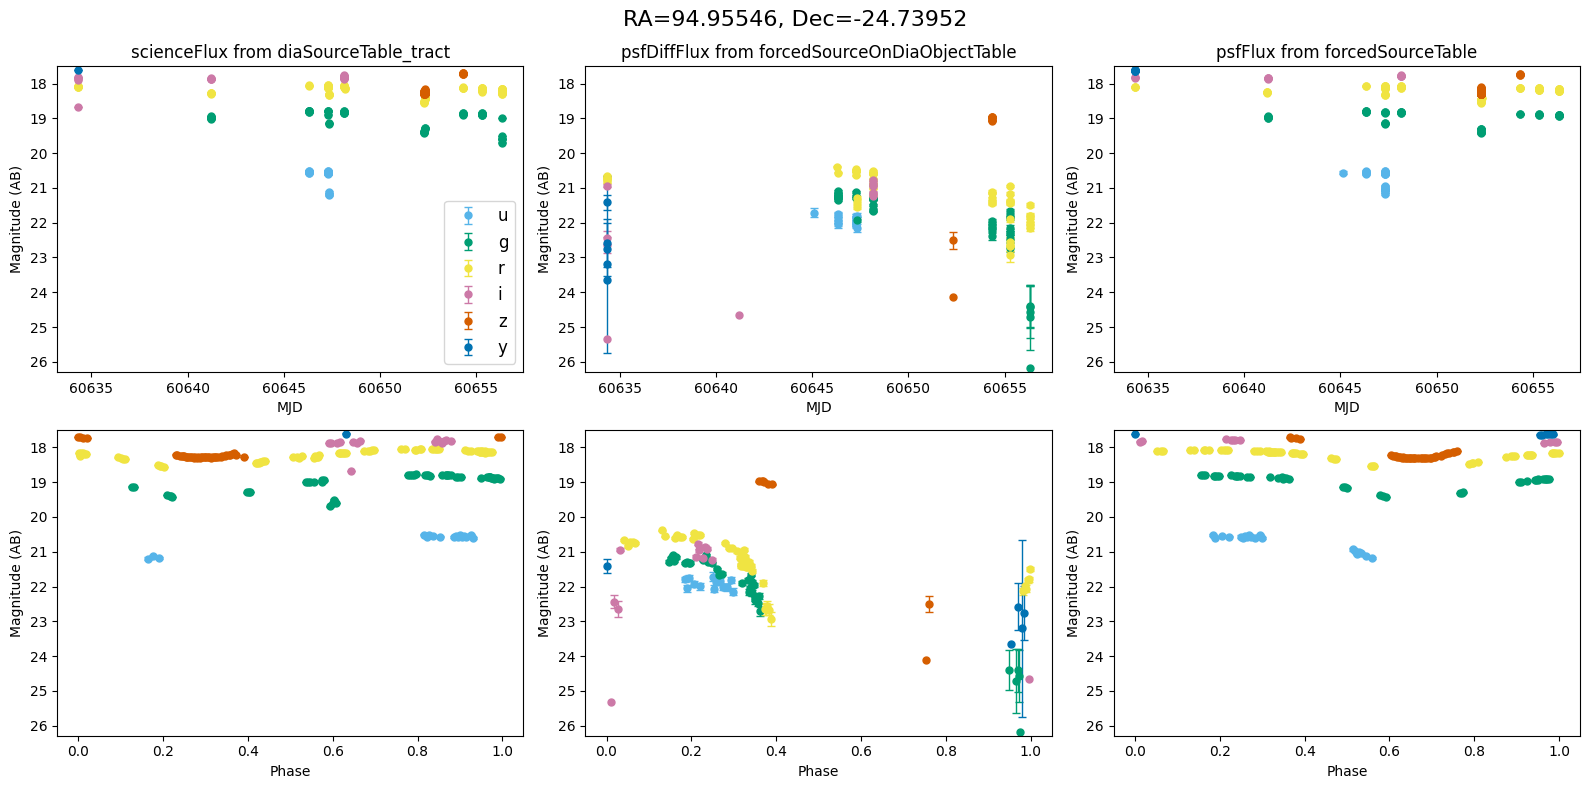

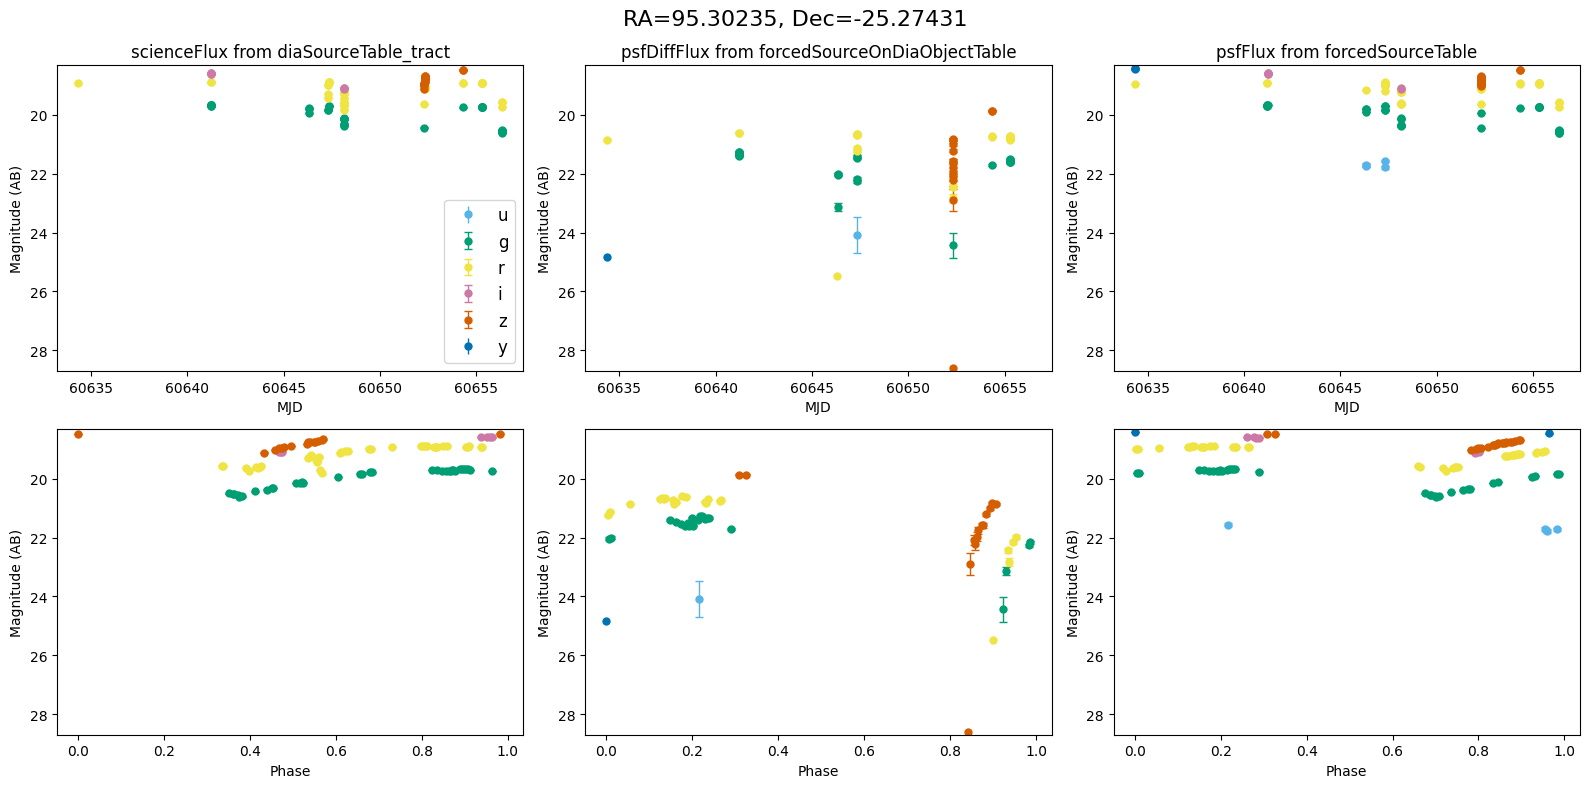

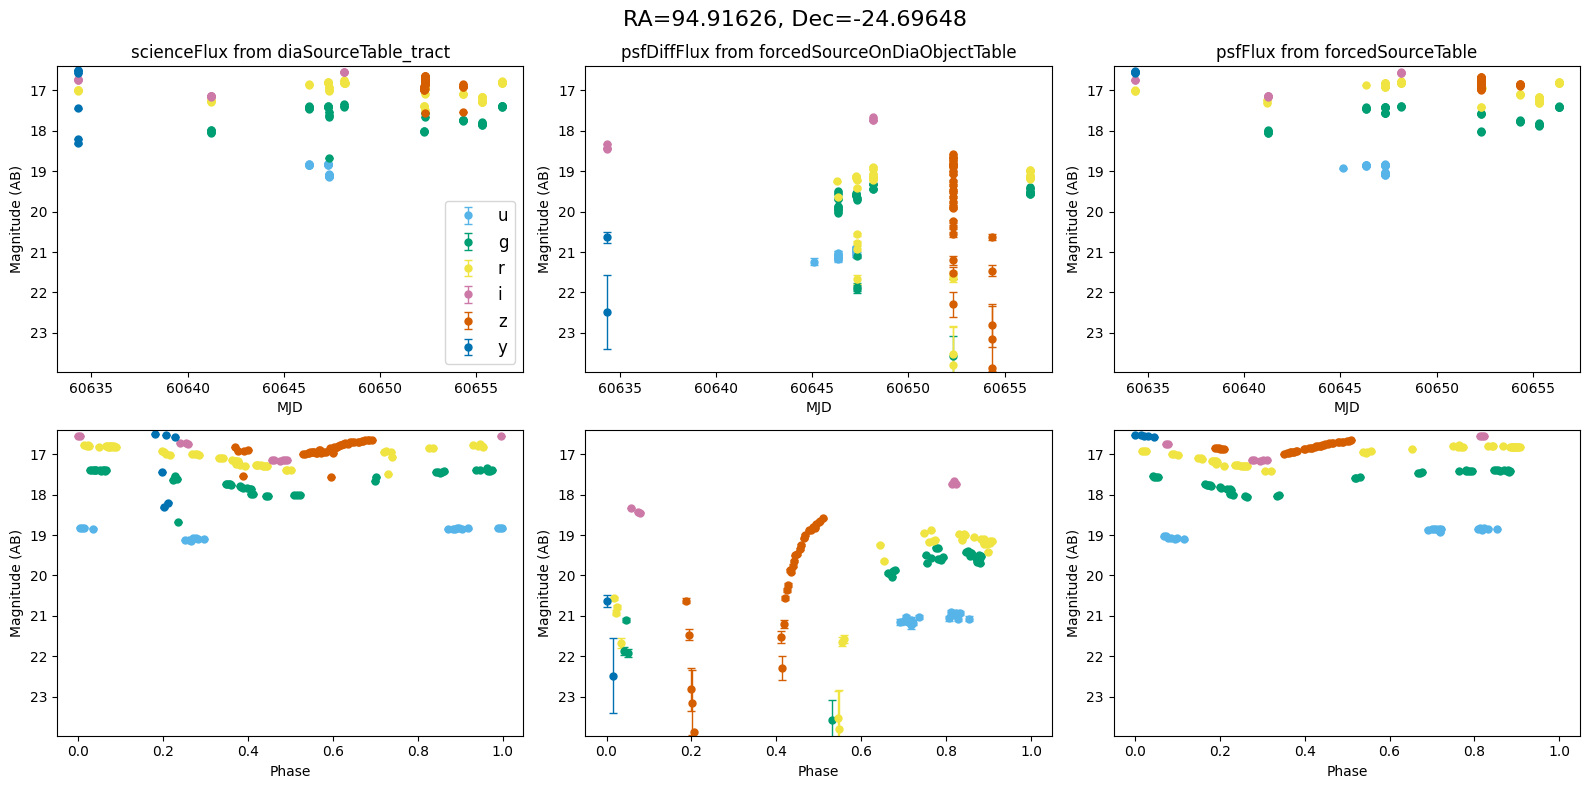

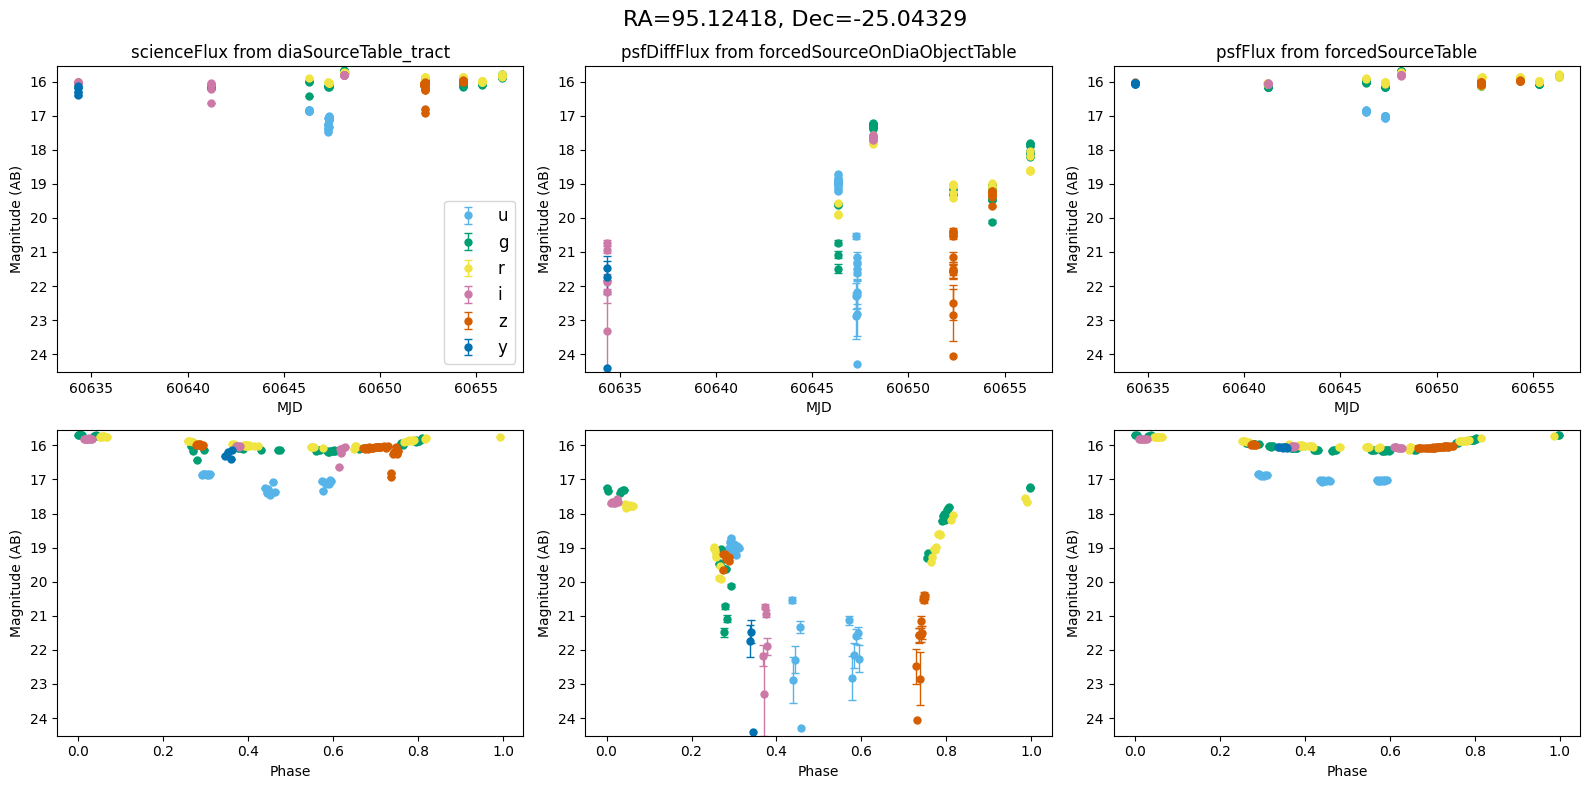

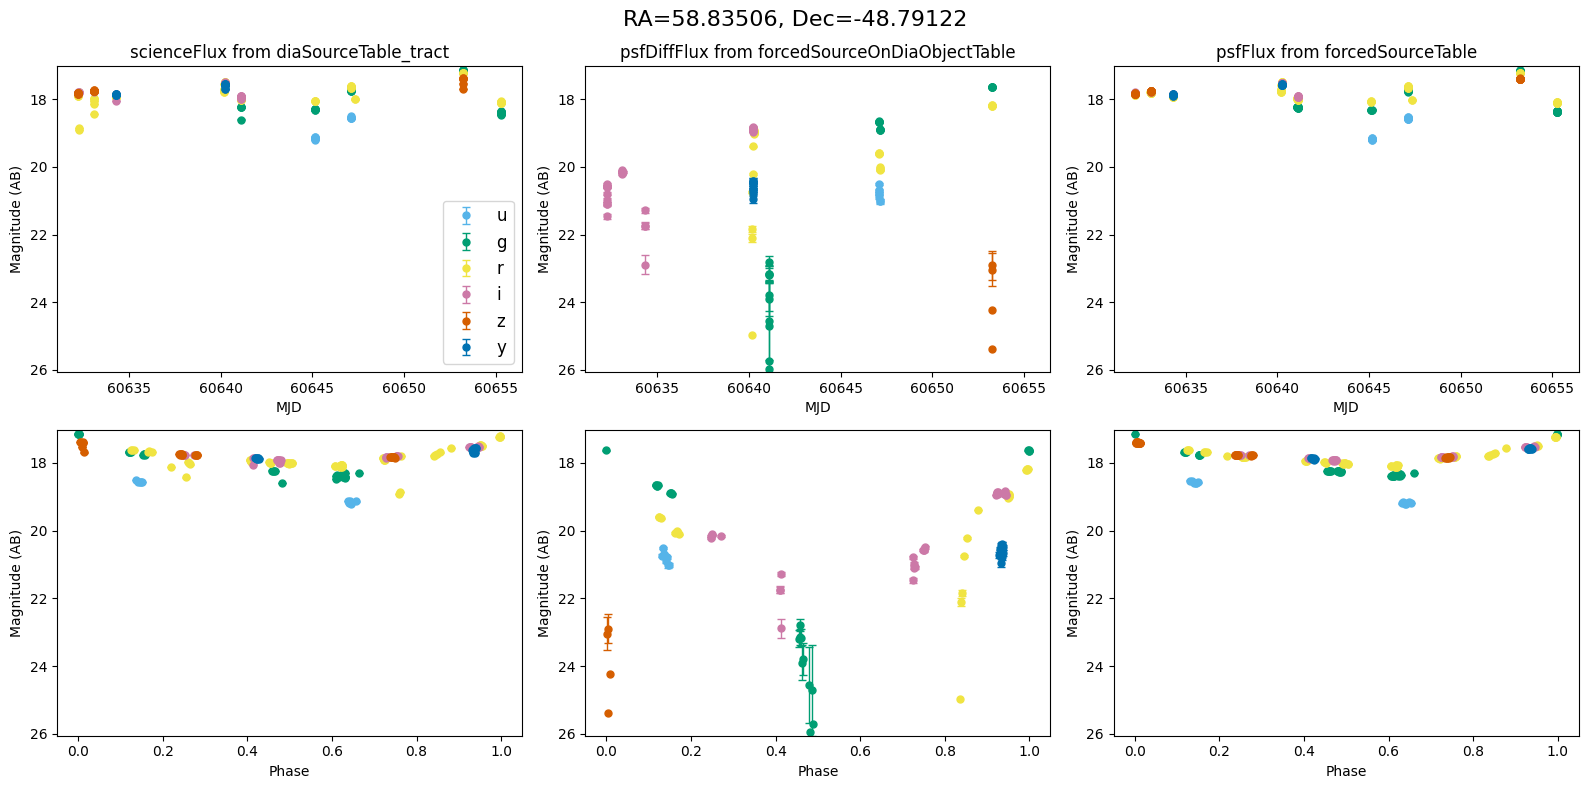

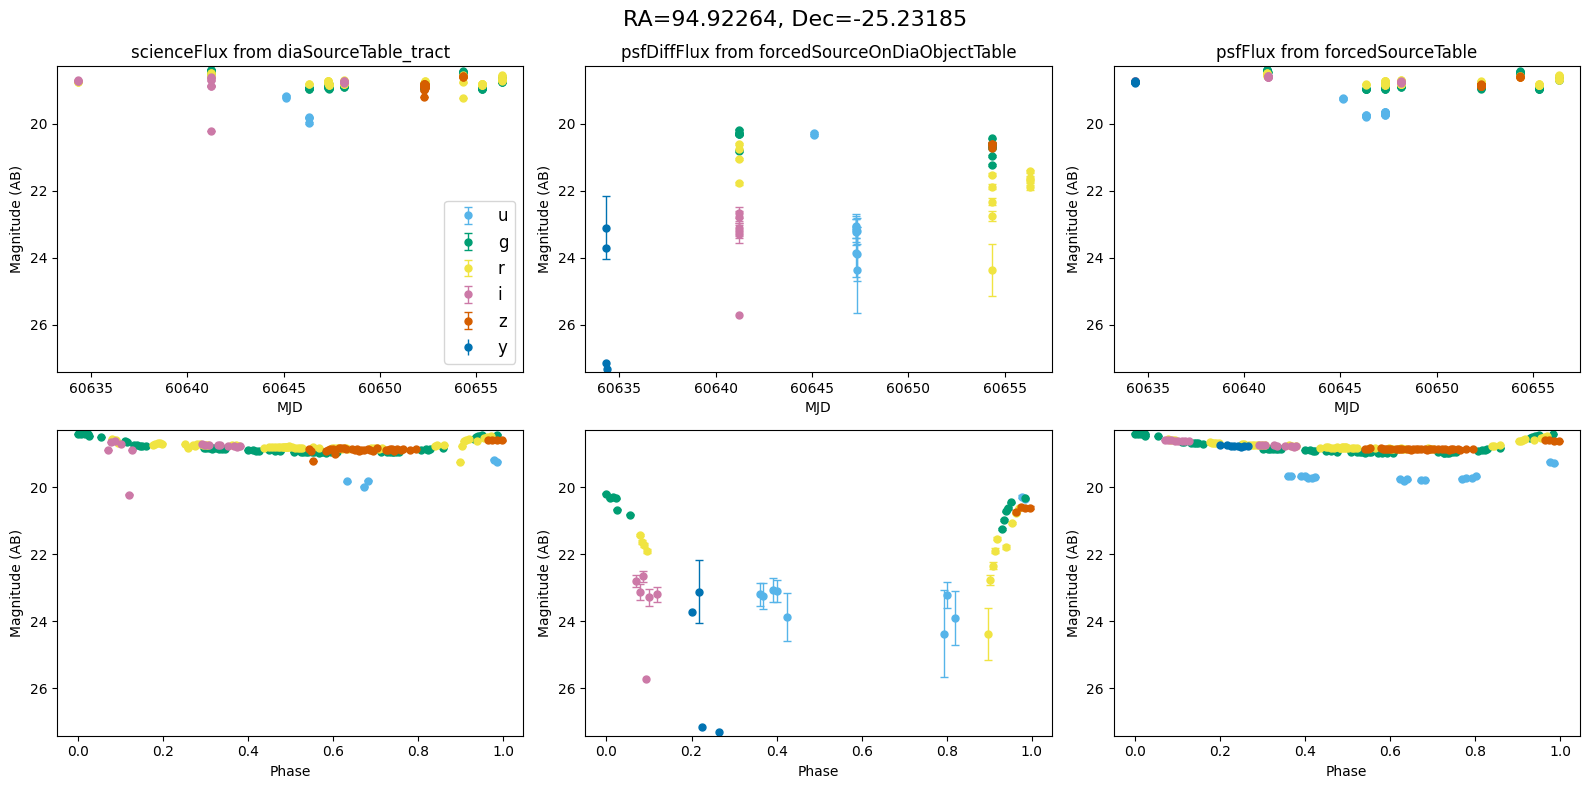

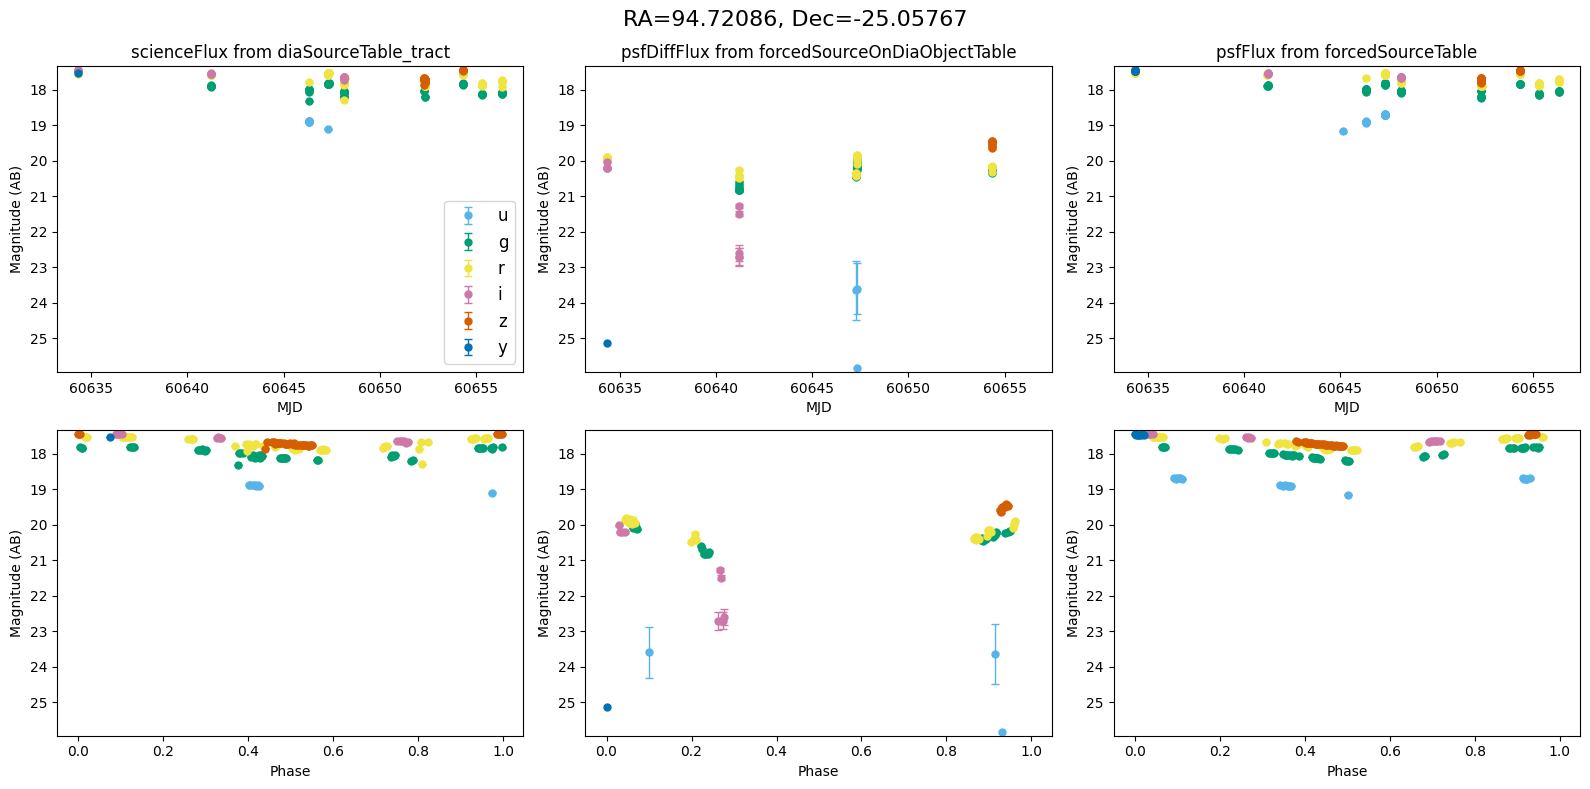

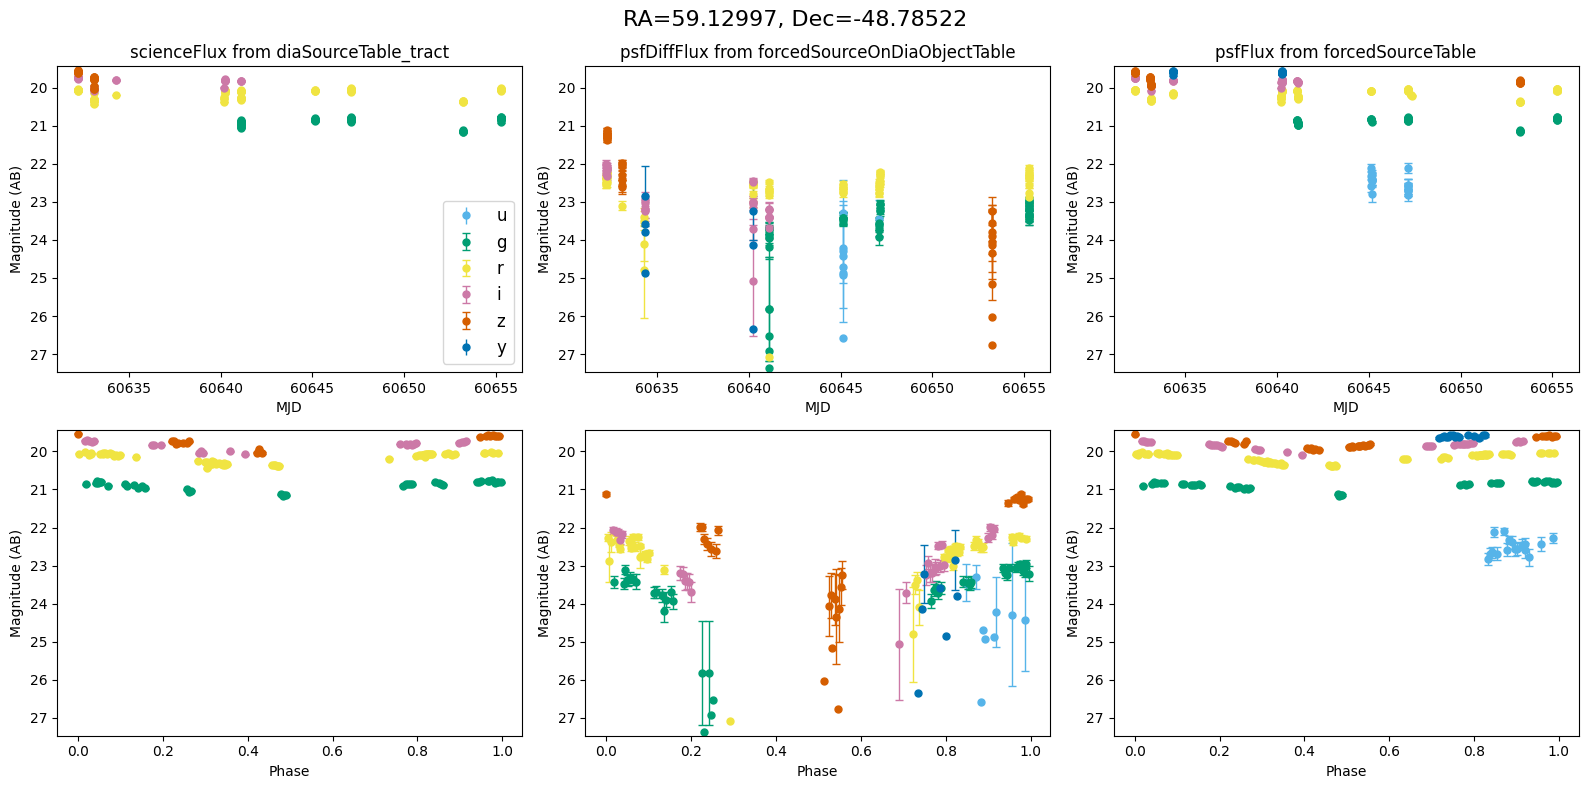

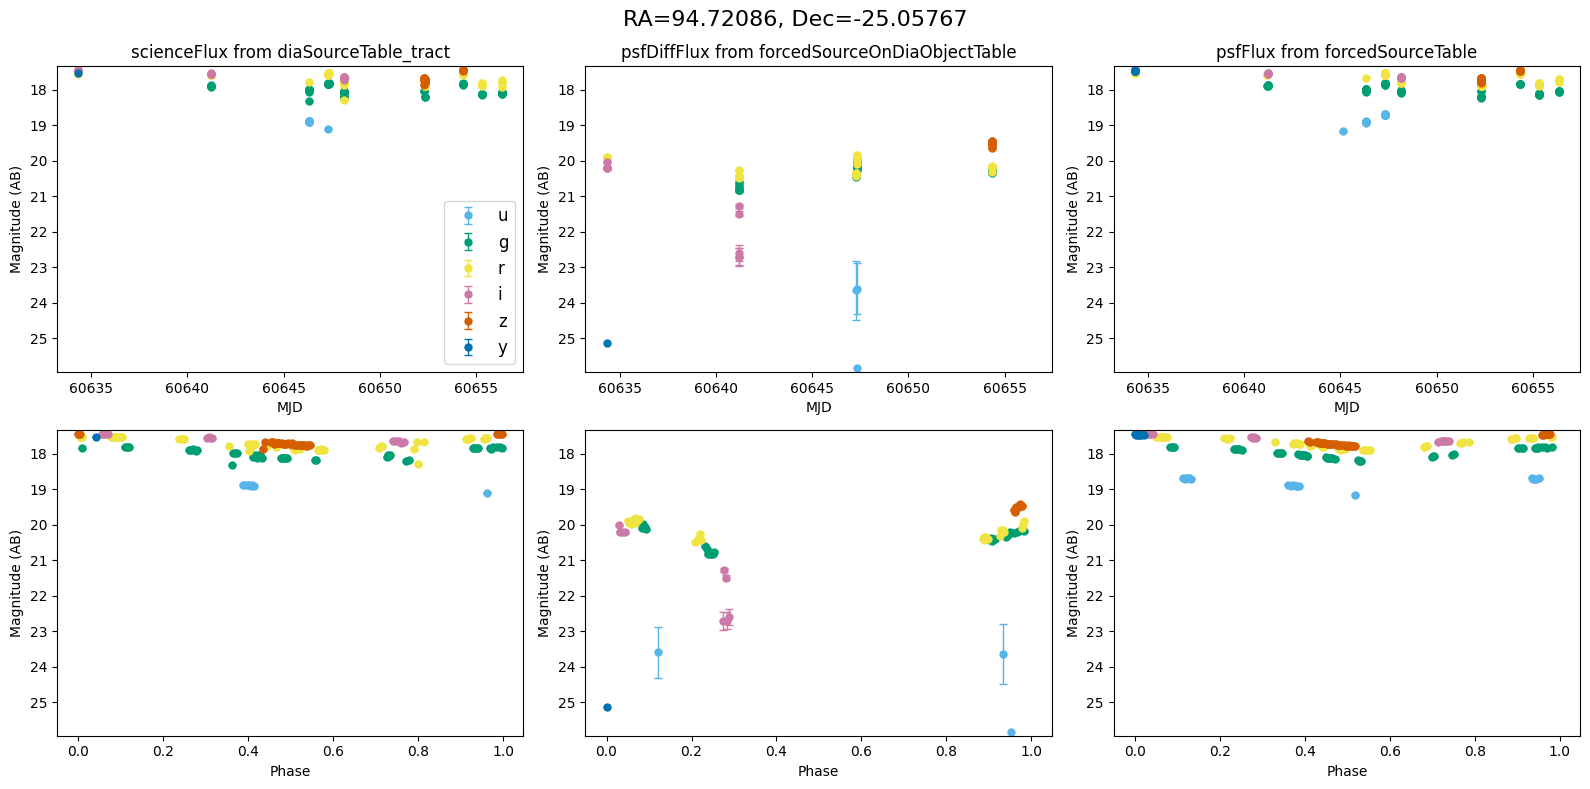

In [12]:
for _, row in result_df.iterrows():
    fig, ax = plt.subplots(2, 3, figsize=(16, 8), sharex="row")  # 2 rows, 3 columns
    fig.suptitle(
        f"RA={row.ra_var_obj:.5f}, Dec={row.dec_var_obj:.5f}",
        fontsize=16,
    )
    all_mags = plot_mag_lightcurves(ax, row)
    scale_mag_y_axis(ax, all_mags)
    plt.tight_layout()
    plt.show()

### In the flux scale

In [13]:
def plot_flux_lightcurves(ax, row):
    """Plot flux light curves from DIA source, DIA forced source and forcedSource"""
    # Define flux types for each dataset
    datasets = [
        ("scienceFlux", "diaSourceTable_tract", row.diaSource_dia),
        ("psfDiffFlux", "forcedSourceOnDiaObjectTable", row.diaObjectForcedSource_dia),
        ("psfFlux", "forcedSourceTable", row.objectForcedSource_obj),
    ]
    all_flux = [[], [], []]  # To store flux for each row
    for i, (flux_col, table_name, lc) in enumerate(datasets):
        title = f"{flux_col} from {table_name}"
        flux_err_col = f"{flux_col}Err"
        ax[0, i].set_title(title)
        # Compute phase
        lc = lc.assign(
            phase=(lc.midpointMjdTai - lc.midpointMjdTai.loc[lc.psfFlux.idxmax()])
            % row.period_var_obj
            / row.period_var_obj
        )
        # First row: original light curve
        all_flux[i].extend(
            plot_flux_scale(
                ax[0, i],
                lc,
                flux_col,
                flux_err_col,
                x_name="midpointMjdTai",
                x_label="MJD",
                show_legend=(i == 0),
            )
        )
        # Second row: folded light curve
        all_flux[i].extend(
            plot_flux_scale(ax[1, i], lc, flux_col, flux_err_col, x_name="phase", x_label="Phase")
        )
    return all_flux


def plot_flux_scale(ax, lc, flux_col, flux_err_col, x_name, x_label, show_legend=False):
    """Function to plot light curves in flux scale"""
    flux_values = []  # Store flux values for setting axis limits
    for band, color in COLORS.items():
        band_lc = lc.query(f"band == '{band}'")
        # Extract flux values and errors directly
        flux = band_lc[flux_col]
        flux_err = band_lc[flux_err_col]
        ax.errorbar(
            band_lc[x_name],
            flux,
            flux_err,
            fmt="o",
            label=band,
            color=color,
            alpha=1,
            markersize=5,
            capsize=3,
            elinewidth=1,
        )
        flux_values.extend(flux.dropna().values)  # Collect flux values
    ax.set_xlabel(x_label, fontsize=14)  # Increased font size
    ax.set_ylabel(f"{flux_col} (nJy)", fontsize=14)  # Increased font size
    if show_legend:
        ax.legend(loc="lower right", fontsize=12)  # Show legend in top-left panel only
    return flux_values  # Return flux values for axis scaling


def scale_flux_y_axis(ax, all_flux):
    """Set uniform y-axis scaling for first and third columns, while middle remains independent and symmetric"""
    for row_idx in range(2):
        for col_idx in [0, 2]:  # Apply shared limits to first and third columns
            if all_flux[col_idx]:  # Ensure we have data
                ymin, ymax = np.nanmin(all_flux[col_idx]), np.nanmax(all_flux[col_idx])
                ax[row_idx, col_idx].set_ylim(ymin - 0.1 * abs(ymin), ymax + 0.1 * abs(ymax))  # Add buffer
        # Middle column (psfDiffFlux) gets independent, symmetric scaling
        if all_flux[1]:
            max_abs_flux = np.nanmax(np.abs(all_flux[1]))  # Find the maximum absolute value
            ax[row_idx, 1].set_ylim(-max_abs_flux * 1.1, max_abs_flux * 1.1)  # Symmetric range around 0

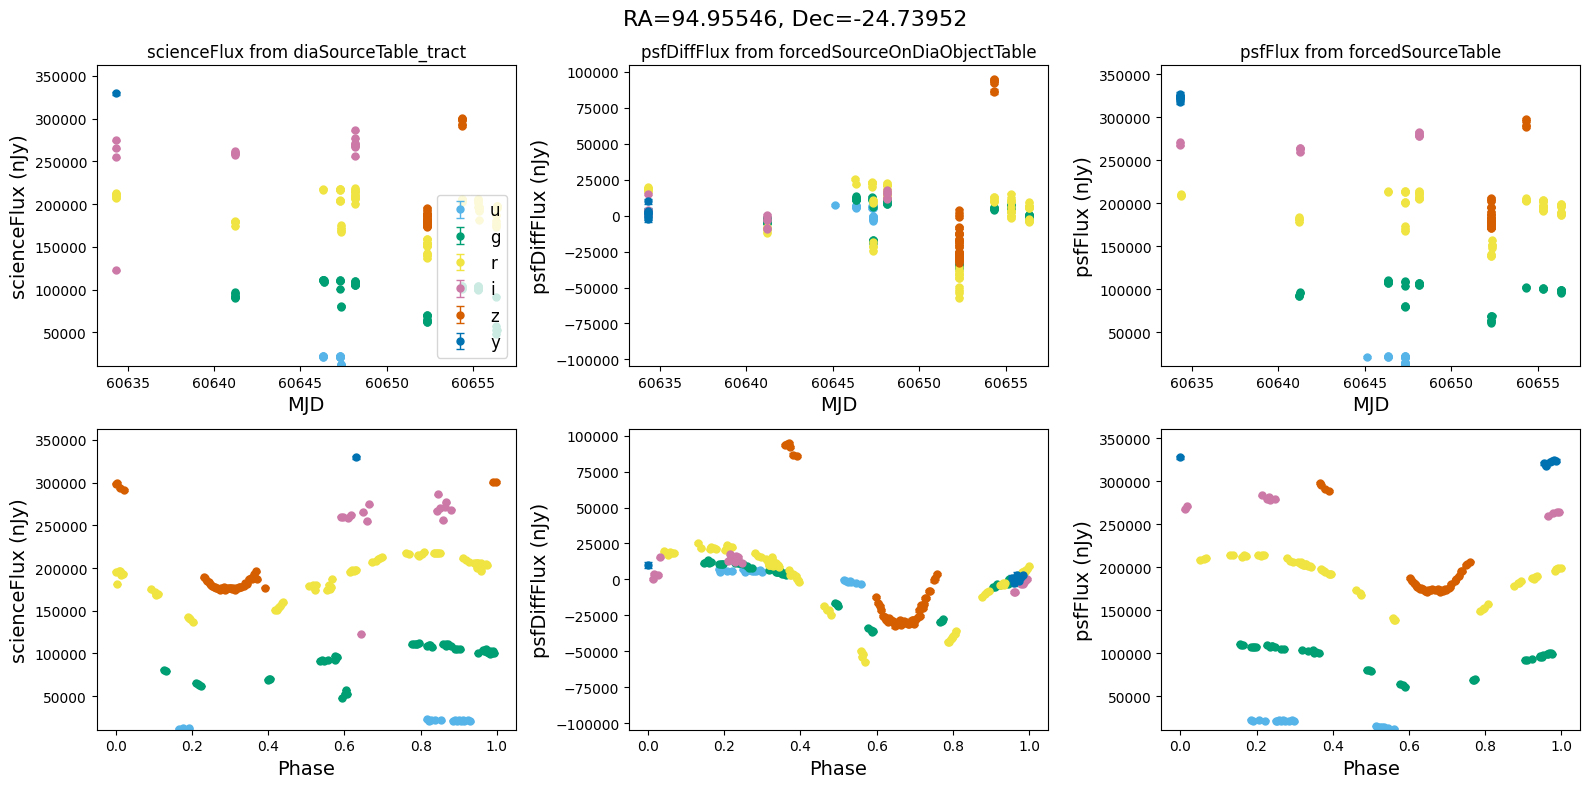

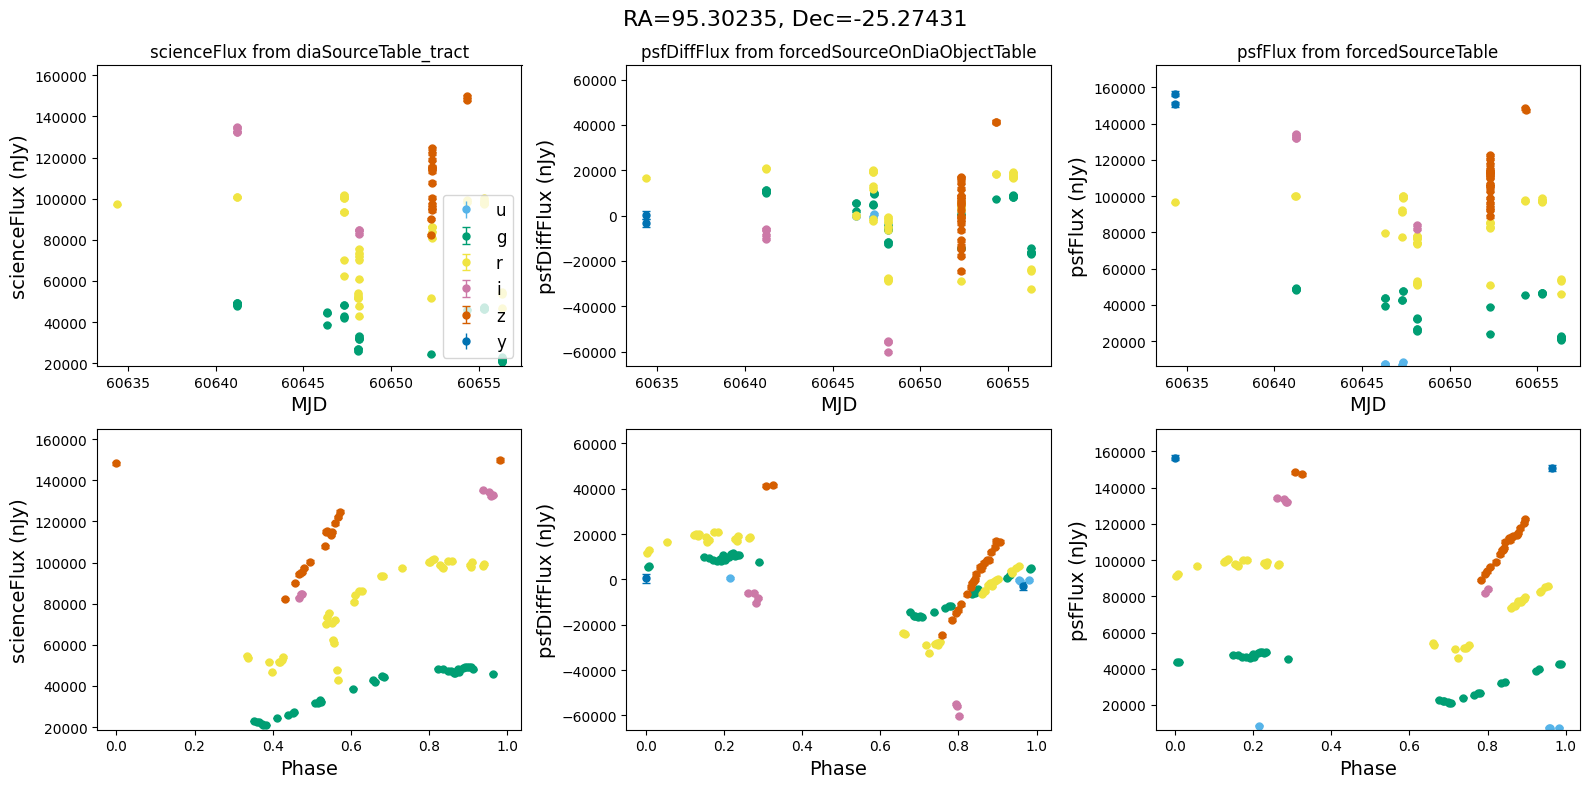

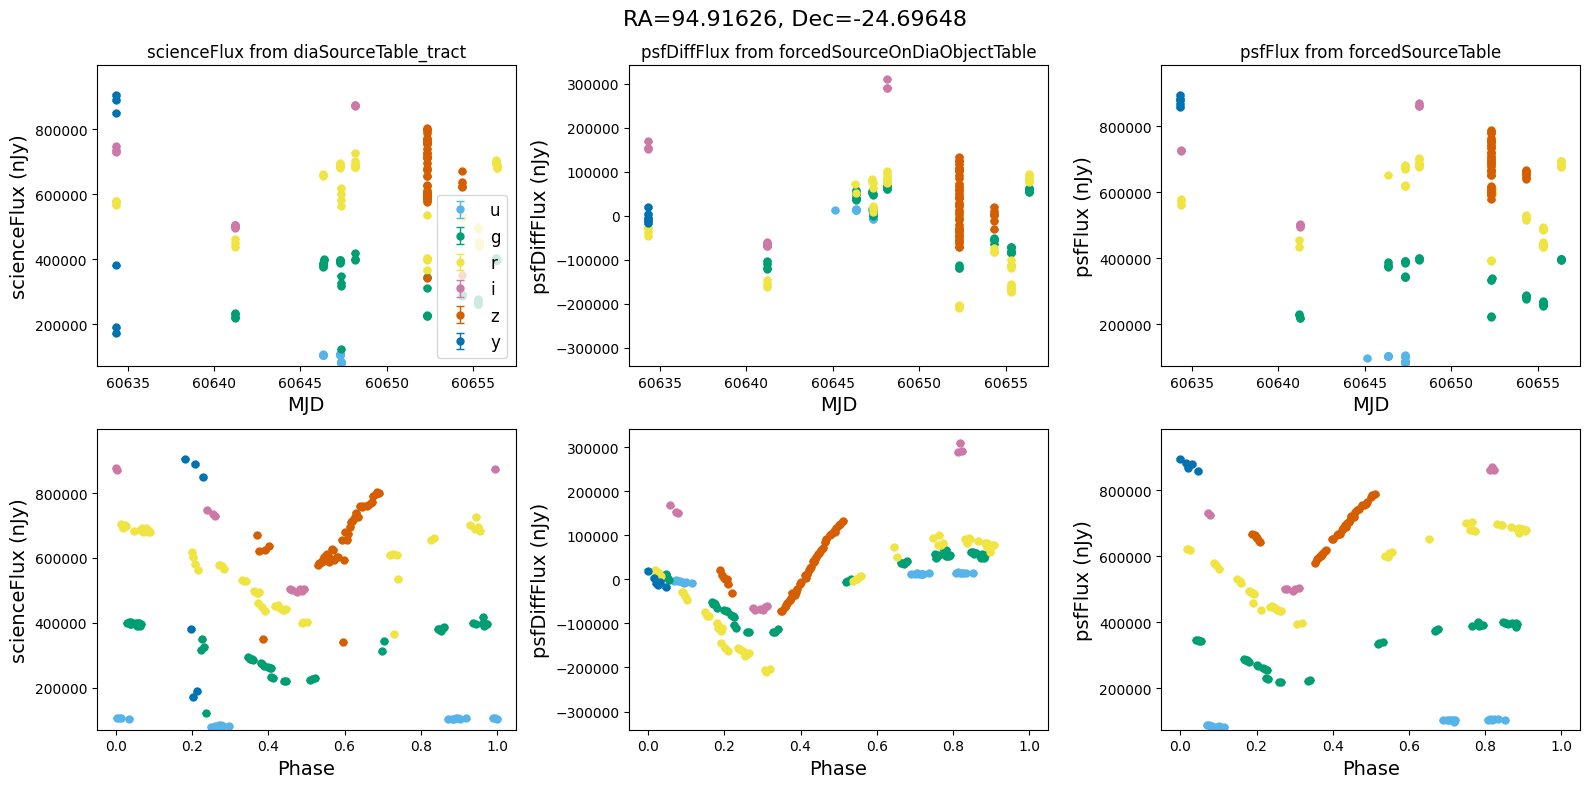

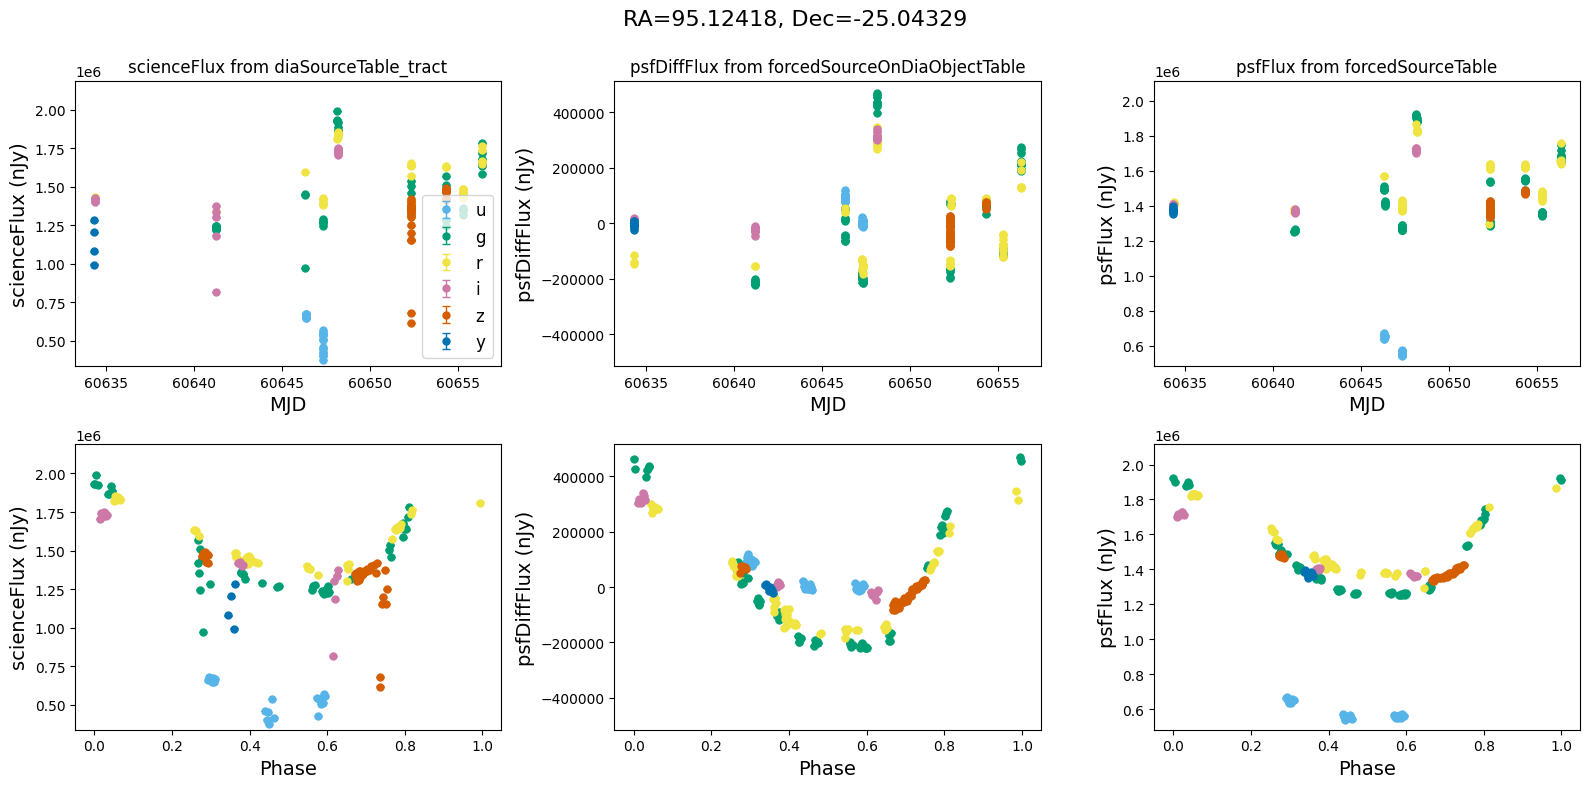

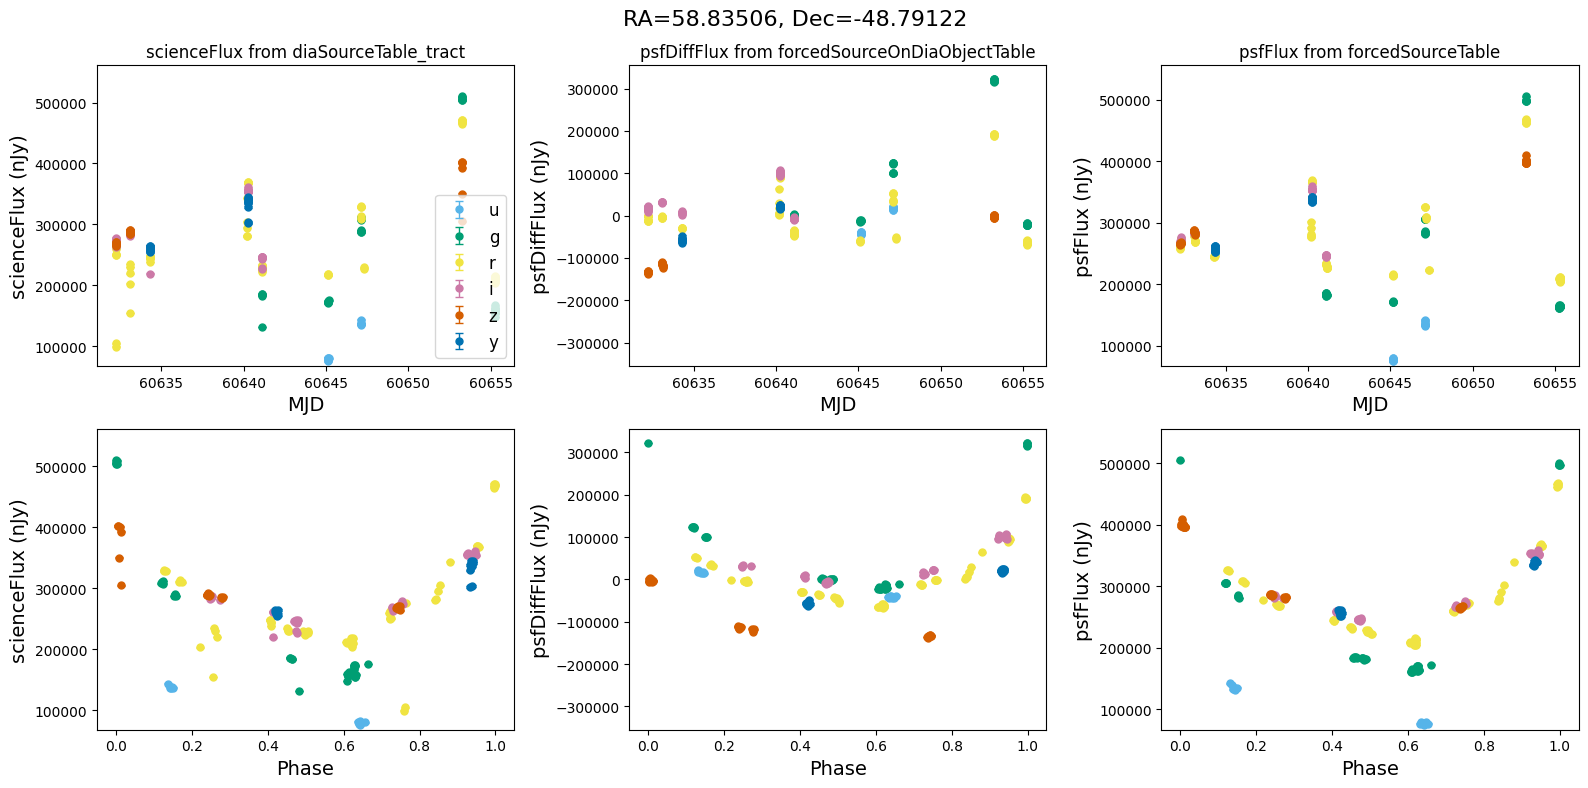

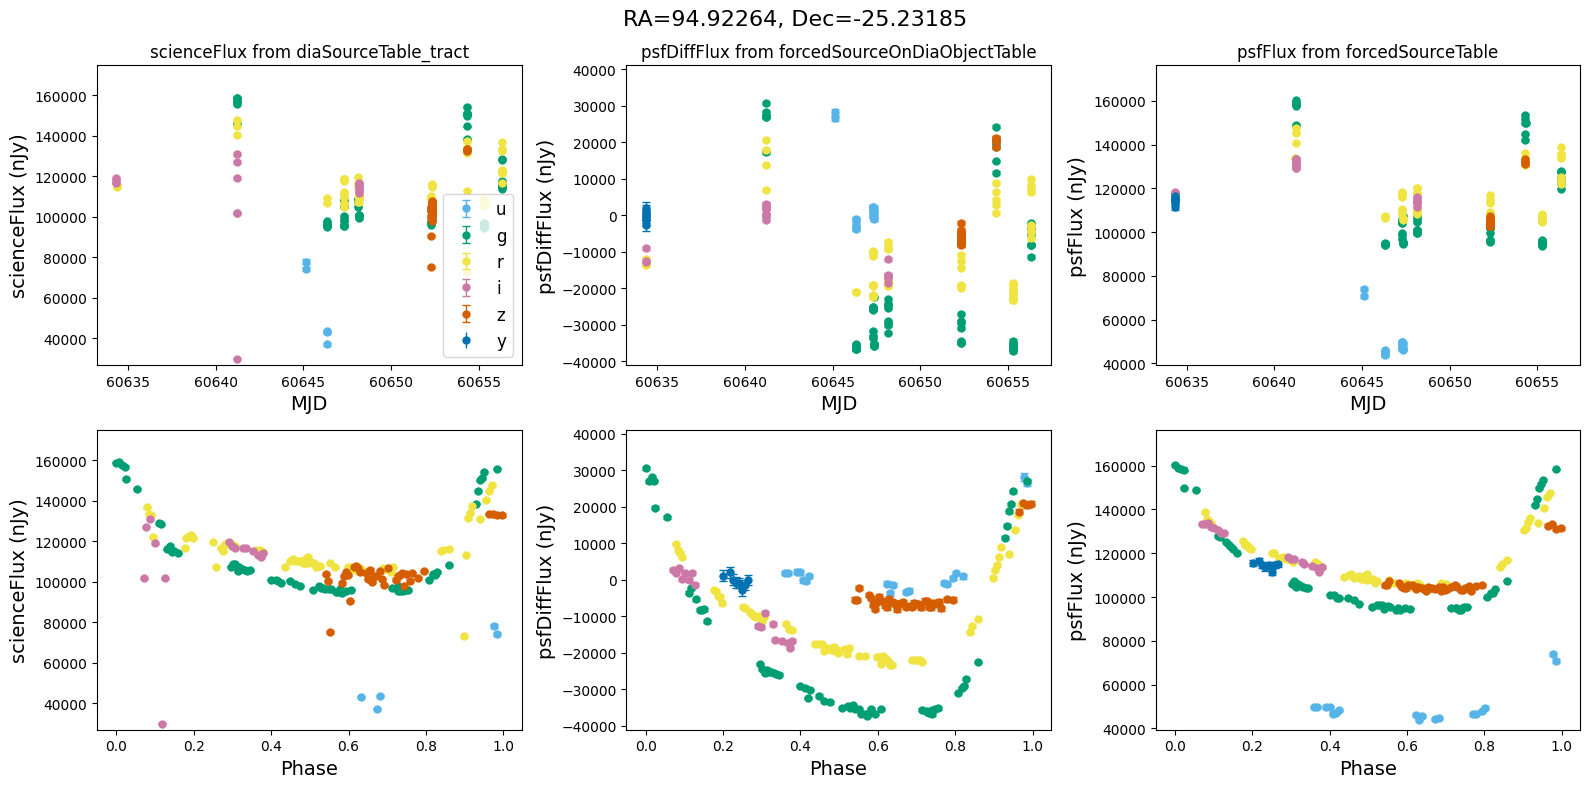

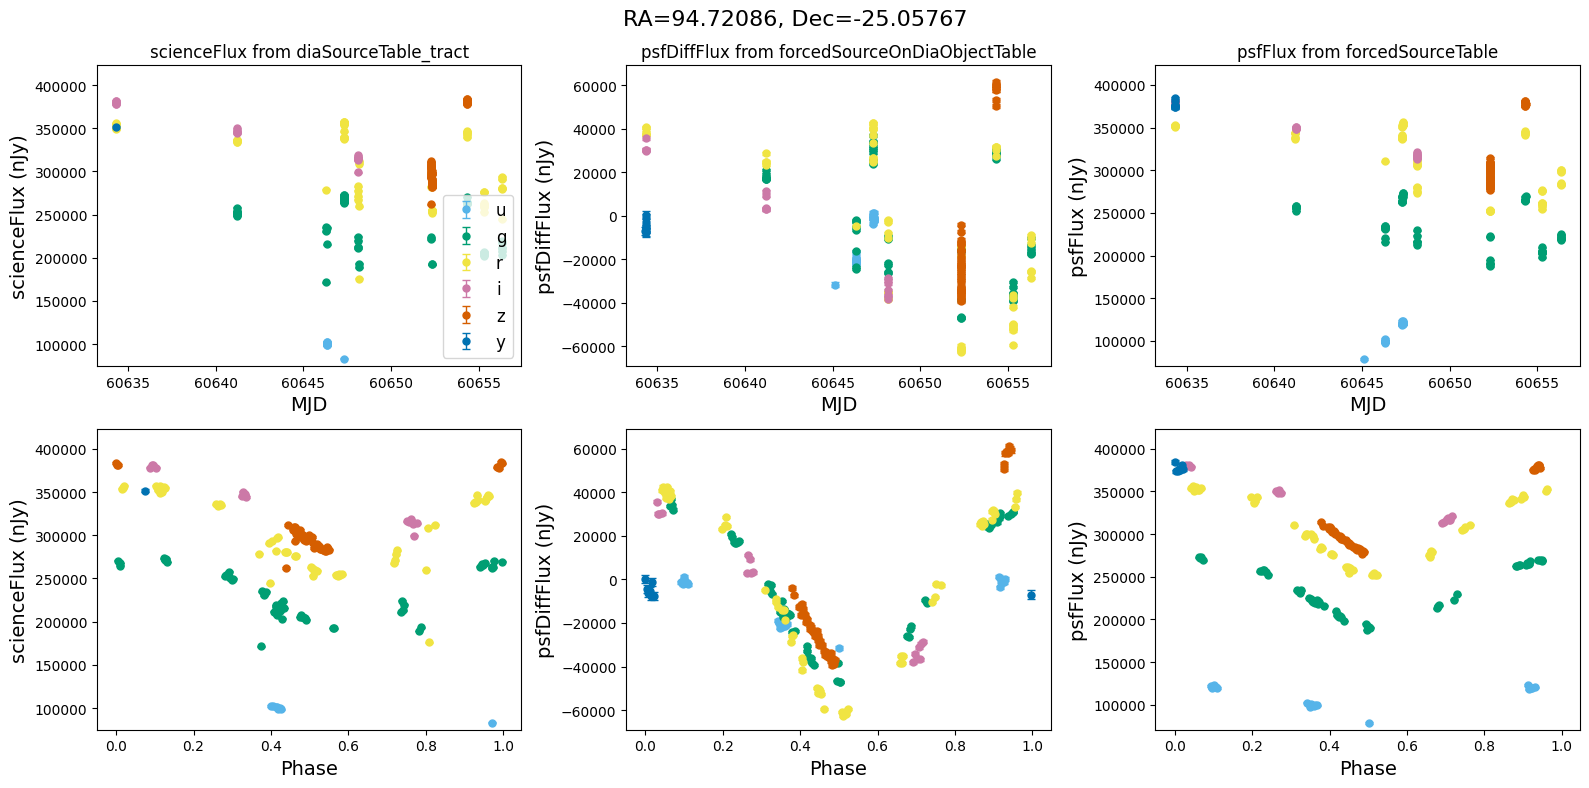

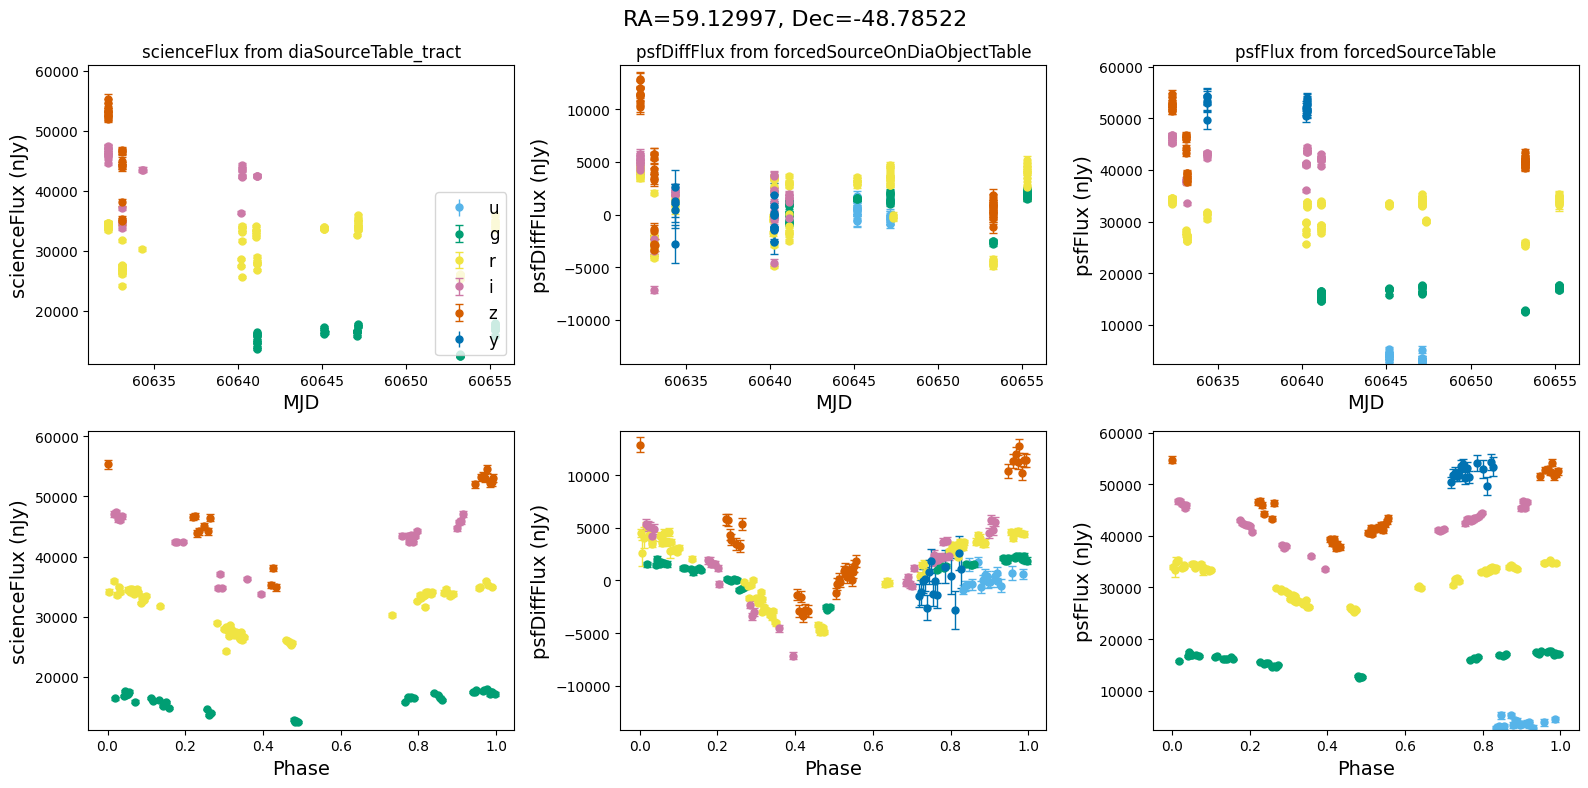

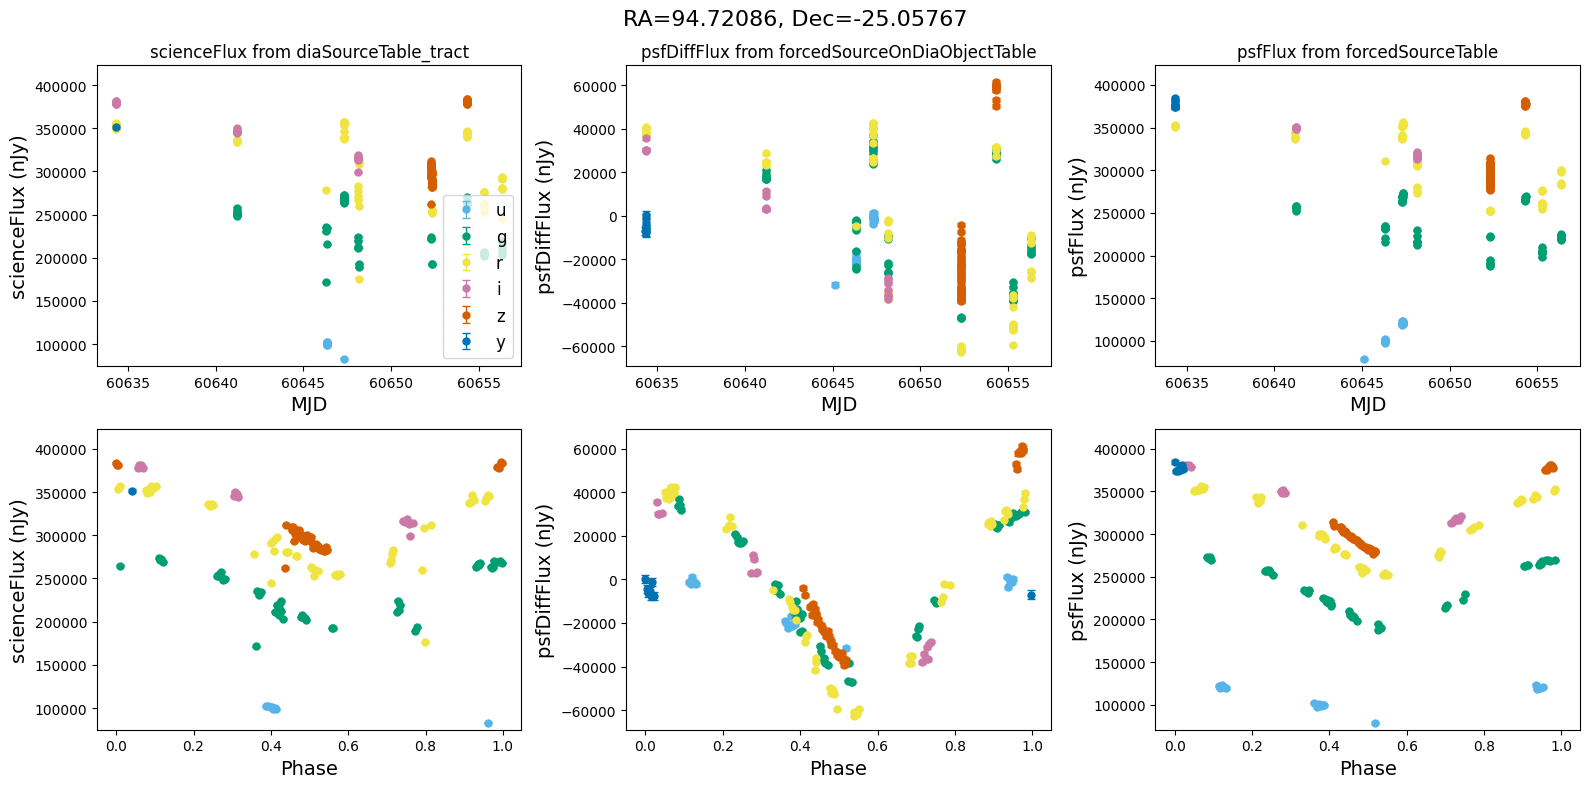

In [14]:
for _, row in result_df.iterrows():
    fig, ax = plt.subplots(2, 3, figsize=(16, 8), sharex="row")  # 2 rows, 3 columns
    fig.suptitle(
        f"RA={row.ra_var_obj:.5f}, Dec={row.dec_var_obj:.5f}",
        fontsize=16,
    )
    all_flux = plot_flux_lightcurves(ax, row)
    scale_flux_y_axis(ax, all_flux)
    plt.tight_layout()
    plt.show()

## About
**Author(s):** Sandro Campos, Doug Branton

**Last updated on:** 27 June 2025

If you use lsdb for published research, please cite following [instructions](https://docs.lsdb.io/en/stable/citation.html).